### coherency in time and space for detecting organizaiton

In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# aggregation indices
os.chdir('/w2-data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA

In [4]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N

    y_avg = np.convolve(y, avg_mask, 'same')
    y_avg[-window_N:] = y[-window_N:]
    y_avg[:window_N] = y[:window_N]
    return y_avg    

In [5]:
def read_data(data_dir,t_start=0,t_end=1081):
    os.chdir(data_dir)
    print(data_dir)
    file_name = glob('*nc')
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
    data_3d = xr.open_dataset('cm1out_sub3d.nc')
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    
    #3d data
    th3d = data_3d.th[t_start:t_end,:45,:,:]
    v3d = data_3d.vinterp[t_start:t_end,:45,:,:]
    u3d = data_3d.uinterp[t_start:t_end,:45,:,:]
    w3d = data_3d.winterp[t_start:t_end,:45,:,:]
    
    # zonal mean data
    th = data_zon.th[t_start:t_end,:,:,:]
    qv = data_zon.qv[t_start:t_end,:,:,:]
#     u = data_zon.uinterp[t_start:t_end,:,:,:]
#     v = data_zon.vinterp[t_start:t_end,:,:,:]
#     w = data_zon.winterp[t_start:t_end,:,:,:]
    qc = data_zon.qc[t_start:t_end,:,:,:]
    qi = data_zon.qi[t_start:t_end,:,:,:]
    prs = data_zon.prs[t_start:t_end,:,:,:]
    # 2d data
    prate = data_2d.prate[t_start:t_end,:,:]
    pwat = data_2d.pwat[t_start:t_end,:,:]
    cwp = data_2d.cwp[t_start:t_end,:,:]
    cape = data_2d.cape[t_start:t_end,:,:]
    cin = data_2d.cin[t_start:t_end,:,:]
    
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))

    x_dim = data_2d.lon
    y_dim = data_2d.lat
#    div = np.gradient(v,y_dim*1000,axis=2) # du/dx+dv/dy 
#    vor = -np.gradient(u,y_dim*1000,axis=2) # -du/dy+dv/dx
    #relative humidty calculation, Buck (1996)
    es_liq = 0.61121*np.exp((18.678-T/234.5)*(T/(257.14+T)))*10 #[hpa]
    es_ice = 0.61115*np.exp((23.036-T/333.7)*(T/(279.82+T)))*10

    qs_liq = 0.622*es_liq/(prs/100-es_liq)
    qs_ice = 0.622*es_ice/(prs/100-es_ice)

    rh = qv/qs_liq
    rh_ice = qv/qs_ice

    rh = rh.values.flatten()
    rh_ice = rh_ice.values.flatten()
    T_test = T.values.flatten()

    rh[T_test<0] = rh_ice[T_test<0]
    rh = rh.reshape((T.shape[0],T.shape[1],T.shape[2],T.shape[3]))
    rh = xr.DataArray(rh,coords=[T.time,T.lev,T.lat,T.lon],dims=['time','lev','lat','lon'])
    
#    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro,th3d,v3d,u3d)
    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u3d,v3d,w3d,cape,cin,prs,ro,th3d)

In [94]:
# get weather or weather2 
server = '/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_OPENMP_Lowjet_RCEP_120x240',
            'CM1_RAD4K_OPENMP_Midjet_RCEP_120x240',
            'CM1_RAD4K_OPENMP_Highjet_RCEP_120x240',
            'CM1_RAD4K_OPENMP_Lowjet_RCEP_120x240_int',
            'CM1_RAD4K_Lowjet_RCEP_120x240_UNI',
            'CM1_RAD4K_Midjet_RCEP_120x240_UNI',
            'CM1_RAD4K_Highjet_RCEP_120x240_UNI']
exp_short = ['LOW','MID','UPP','LOW_INT','LOW_UNI','MID_UNI','UPP_UNI']

os.chdir(server)
os.system('mkdir -p fig_sum') # create a figure archive
fig_dir = server+'fig_sum/' 

In [83]:
(th1,T1,qv1,qc1,qi1,rh1,prate1,pwat1,cwp1,u3d1,v3d1,w3d1,cape1,cin1,prs1,ro1,th3d1) = read_data(server+exp_name[0],t_start=360)
(th2,T2,qv2,qc2,qi2,rh2,prate2,pwat2,cwp2,u3d2,v3d2,w3d2,cape2,cin2,prs2,ro2,th3d2) = read_data(server+exp_name[1],t_start=360)
(th3,T3,qv3,qc3,qi3,rh3,prate3,pwat3,cwp3,u3d3,v3d3,w3d3,cape3,cin3,prs3,ro3,th3d3) = read_data(server+exp_name[2],t_start=360)
(th4,T4,qv4,qc4,qi4,rh4,prate4,pwat4,cwp4,u3d4,v3d4,w3d4,cape4,cin4,prs4,ro4,th3d4) = read_data(server+exp_name[3],t_start=360)
(th5,T5,qv5,qc5,qi5,rh5,prate5,pwat5,cwp5,u3d5,v3d5,w3d5,cape5,cin5,prs5,ro5,th3d5) = read_data(server+exp_name[4],t_start=360)
(th6,T6,qv6,qc6,qi6,rh6,prate6,pwat6,cwp6,u3d6,v3d6,w3d6,cape6,cin6,prs6,ro6,th3d6) = read_data(server+exp_name[5],t_start=360)
(th7,T7,qv7,qc7,qi7,rh7,prate7,pwat7,cwp7,u3d7,v3d7,w3d7,cape7,cin7,prs7,ro7,th3d7) = read_data(server+exp_name[6],t_start=360)

/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_OPENMP_Lowjet_RCEP_120x240
/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_OPENMP_Midjet_RCEP_120x240
/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_OPENMP_Highjet_RCEP_120x240
/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_OPENMP_Lowjet_RCEP_120x240_int
/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_Lowjet_RCEP_120x240_UNI
/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_Midjet_RCEP_120x240_UNI
/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_Highjet_RCEP_120x240_UNI


In [8]:
x_dim = pwat1.lon
y_dim = pwat1.lat
z_dim = T1.lev
t_dim = np.arange(len(T1.time))/3

In [11]:
data_ctr = xr.open_dataset('/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_MPI_SFXint/cm1out_sub3d.nc')
th3d_ctr = data_ctr.th

In [47]:
# reshape CTRL 120km into 240km. Thanks for the double periodic
th3d_ctrl = xr.concat([th3d_ctr,th3d_ctr],dim='lat') 

Text(350, 400, 'UPP')

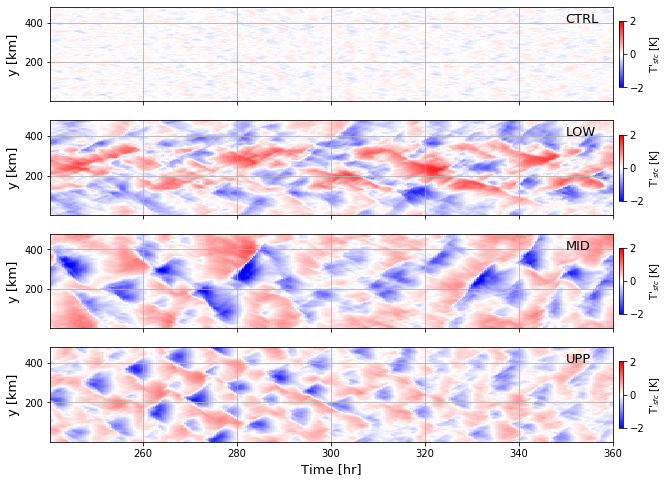

In [70]:
fig,ax = plt.subplots(4,1,figsize=(12,8))
for n, th3d in enumerate([th3d_ctrl,th3d2,th3d3,th3d4]):
    cf=ax[n].pcolormesh(t_dim[-360:],y_dim,(th3d[-360:,0,:,:].mean('lon')-th3d[-360:,0,:,:].mean(('lon','lat'))).T
                     ,cmap='bwr',vmin=-2,vmax=2)
    cbar = plt.colorbar(cf,ax=ax[n],shrink=0.7,pad=0.01)
    cbar.set_label("T'$_{sfc}$ [K]")
    ax[n].set_ylabel('y [km]',fontsize=13)
    ax[n].grid()
    if n == 3:
        ax[n].set_xlabel('Time [hr]',fontsize=13)
    else:
        ax[n].set_xticklabels([])
ax[0].text(350,400,exp_short[0],fontsize=13)
ax[1].text(350,400,exp_short[1],fontsize=13)
ax[2].text(350,400,exp_short[2],fontsize=13)
ax[3].text(350,400,exp_short[3],fontsize=13)

In [78]:
def lag_coeff(x):
    "x is a 1d array"
    coeff = np.empty(x.size)
    for lag in range(x.size):
        coeff[lag] = np.corrcoef(x,np.roll(x,lag))[0,1] # return lag coefficient
    return coeff

In [84]:
auto_coeff_ctr = np.empty((360,120))
thvar_yt = (th3d_ctrl[-360:,0,:,:].mean('lon')-th3d_ctrl[-360:,0,:,:].mean(('lon','lat')))
for t in range(360):
    auto_coeff_ctr[t,:] = lag_coeff(thvar_yt[t,60:180])

auto_coeff_s = np.empty((len(exp_name),360,120))
auto_coeff_ns = np.copy(auto_coeff_s)
    
for n,th3d in enumerate([th3d1,th3d2,th3d3,th3d4,th3d5,th3d6,th3d7]):

    thvar_yt = (th3d[-360:,0,:,:].mean('lon')-th3d[-360:,0,:,:].mean(('lon','lat')))
    thvar_yt_s = thvar_yt[:,60:180]
    thvar_yt_ns =  np.concatenate([thvar_yt[:,:60],thvar_yt[:,-60:]],axis=1)

    for t in range(360):
        auto_coeff_s[n,t,:] = lag_coeff(thvar_yt_s[t,:])
        auto_coeff_ns[n,t,:] = lag_coeff(thvar_yt_ns[t,:])

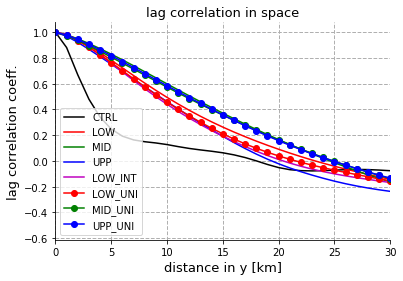

In [102]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
colors = ['r','g','b','m','r','g','b']

ax.plot(auto_coeff_ctr[:,:].mean(axis=0),'-',color='k')
for n in range(len(exp_short)):
    if n <= 3:
        ax.plot(auto_coeff_s[n,:,:].mean(axis=0),'-',color=colors[n])
    else:
        ax.plot(auto_coeff_s[n,:,:].mean(axis=0),'-o',color=colors[n])
ax.legend(['CTRL']+exp_short)
ax.set_xlim([0,30])
#ax.set_xticks(ticks=[0,3,6,9,12,15,18,21]);ax.set_xticklabels([0,6,12,18,24,30,36,42])
ax.set_xlabel('distance in y [km]',fontsize=13)
ax.set_ylabel('lag correlation coeff.',fontsize=13)
ax.set_title('lag correlation in space',fontsize=13)
ax.grid(linestyle='--',linewidth=1)#;ax.set_ylim([-0.2,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#fig.savefig(fig_dir+'lag_coeff_thvariance_space.pdf',bbox_inches='tight',transparent=False)

In [101]:
# correlation in time
auto_coeff_ctr_t = np.empty((360,120))
thvar_yt = (th3d_ctrl[-360:,0,:,:].mean('lon')-th3d_ctrl[-360:,0,:,:].mean(('lon','lat')))
for y in range(120):
    auto_coeff_ctr_t[:,y] = lag_coeff(thvar_yt[:,60+y])

# autocorrelation in time
auto_coeff_s_t = np.empty((len(exp_name),360,120))
auto_coeff_ns_t = np.copy(auto_coeff_s_t)

for n,th3d in enumerate([th3d1,th3d2,th3d3,th3d4,th3d5,th3d6,th3d7]):

    thvar_yt = (th3d[-360:,0,:,:].mean('lon')-th3d[-360:,0,:,:].mean(('lon','lat')))
    thvar_yt_s = thvar_yt[:,60:180]
    thvar_yt_ns =  np.concatenate([thvar_yt[:,:60],thvar_yt[:,-60:]],axis=1)
      
    for y in range(120):
        auto_coeff_s_t[n,:,y] = lag_coeff(thvar_yt_s[:,y])
        auto_coeff_ns_t[n,:,y] = lag_coeff(thvar_yt_ns[:,y])

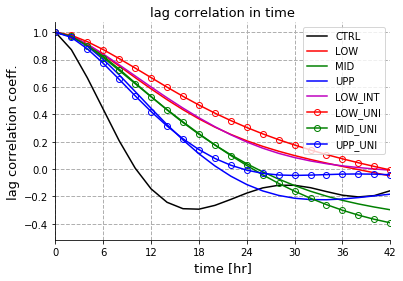

In [127]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
colors = ['r','g','b','m','r','g','b']

ax.plot(auto_coeff_ctr_t[:,:].mean(axis=1),'-',color='k')
for n in range(len(exp_short)):
    if n <= 3:
        ax.plot(auto_coeff_s_t[n,:,:].mean(axis=1),'-',color=colors[n])
    else:
        ax.plot(auto_coeff_s_t[n,:,:].mean(axis=1),'-o',color=colors[n],markerfacecolor='None')
ax.legend(['CTRL']+exp_short)
ax.set_xlim([0,21])
ax.set_xticks(ticks=[0,3,6,9,12,15,18,21]);ax.set_xticklabels([0,6,12,18,24,30,36,42])
ax.set_xlabel('time [hr]',fontsize=13)
ax.set_ylabel('lag correlation coeff.',fontsize=13)
ax.set_title('lag correlation in time',fontsize=13)
ax.grid(linestyle='--',linewidth=1)#;ax.set_ylim([-0.2,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#fig.savefig(fig_dir+'lag_coeff_thvariance_space.pdf',bbox_inches='tight',transparent=False)

In [124]:
# exponential decay in autocorrelation
decay_time = np.empty(len(exp_short))
for n in range(len(exp_short)):
    tmp = auto_coeff_s_t[n,:,:].mean(axis=1)
    for t,coeff in enumerate(tmp):
        if coeff <= 1/np.e:
            decay_time[n] = t
            break
            
tmp = auto_coeff_ctr_t[:,:].mean(axis=1)
for t,coeff in enumerate(tmp):
    if coeff <= 1/np.e:            
        decay_time_ctr = t
        break

In [125]:
decay_time_ctr

4

In [114]:
# fig,ax = plt.subplots(1,1,figsize=(12,4))
# cf=ax.pcolormesh(t_dim[-360:],y_dim,w3d3[-360:,14,:,:].var('lon').T,cmap='jet',vmin=0.5)
# cf.cmap.set_under('w')
# cbar = plt.colorbar(cf,ax=ax,shrink=0.7)
# cbar.set_label('W variance at 3km [m$^2$/s$^2$]')
# ax.set_title(exp_name[1],fontsize=13)
# ax.set_ylabel('y [km]',fontsize=13)
# fig.savefig(fig_dir + 'hovemuller_wvariance_example.pdf',bbox_inches='tight')

In [128]:
## subsidence fraction

colors = ['k','r','g','b','m']
sub_frac_sum = np.empty((len(exp_name),45))
for n,w3d in enumerate([w3d_ctr,w3d2,w3d3,w3d4]):
    
    sub_frac = np.empty((360,45))
    if n == 0:
        for t in range(360):
            for k in range(45):
                sub_frac[t,k] = len(np.where(w3d[-360+t,k,:,:].values.ravel()<-1)[0])/(120*120)
    else:
        for t in range(360):
            for k in range(45):
                sub_frac[t,k] = len(np.where(w3d[-360+t,k,:,:].values.ravel()<-1)[0])/(len(x_dim)*len(y_dim))
    sub_frac_sum[n,:] = sub_frac.mean(axis=0)

In [132]:
## subsidence fraction

colors = ['k','r','g','b','m']
wcore_frac_sum = np.empty((len(exp_name),45))
for n,w3d in enumerate([w3d_ctr,w3d2,w3d3,w3d4]):
    
    wcore_frac = np.empty((360,45))
    if n == 0:
        for t in range(360):
            for k in range(45):
                wcore_frac[t,k] = len(np.where(w3d[-360+t,k,:,:].values.ravel()>1)[0])/(120*120)
    else:
        for t in range(360):
            for k in range(45):
                wcore_frac[t,k] = len(np.where(w3d[-360+t,k,:,:].values.ravel()>1)[0])/(len(x_dim)*len(y_dim))
    wcore_frac_sum[n,:] = wcore_frac.mean(axis=0)

Text(0.5, 0, 'core updraft fraction')

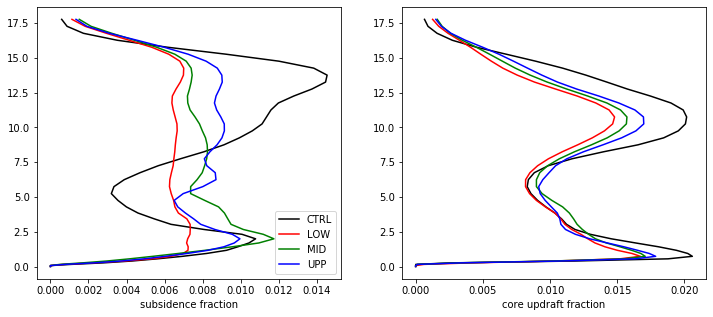

In [133]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
for n in range(4):
    ax[0].plot(sub_frac_sum[n,:],z_dim[:45],color=colors[n])
    ax[1].plot(wcore_frac_sum[n,:],z_dim[:45],color=colors[n])

ax[0].legend(exp_short[:4])
ax[0].set_xlabel('subsidence fraction')
ax[1].set_xlabel('core updraft fraction')